<h1 style="text-align: center;"><b>4.Predictive Analysis</b></h1>

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.simplefilter("ignore", UserWarning)

In [10]:
# Reading both csv

demographic_df = pd.read_csv(r"C:\Febi\NumpyNinja\Hackathon\Python_Launch Folder\Team12_Pytesters_PythonHackathon_August25\demographic_cleandata.csv")
filtered_df = pd.read_csv(r"C:\Febi\NumpyNinja\Hackathon\Python_Launch Folder\Team12_Pytesters_PythonHackathon_August25\filtered_cleandata.csv")

# Merging both csv files for clean analysis
merged_df = filtered_df.merge(demographic_df, on='patient_id', how='left')

## Q1.Can Early Signs of Hypoglycemia Be Predicted from Heart Rate Changes?

**Key reasoning points for prescriptive analysis:**

- **Why heart rate matters:**  
  - Hypoglycemia activates the autonomic nervous system, often increasing heart rate or variability before glucose falls.  
  - CGM glucose sensors have a lag (5–15 minutes); HR changes may give earlier warning.

- **Goal of analysis:**  
  - Predict hypoglycemia onset (e.g., glucose < 70 mg/dL) within the next 15–30 minutes.  
  - Provide actionable alerts to prevent or treat lows.

- **Safety measures:**  
  - Limit alert frequency (e.g., one per 20–30 min).  
  - Combine HR data with glucose trends for confirmation.  
  - Adapt predictions over time to each patient.

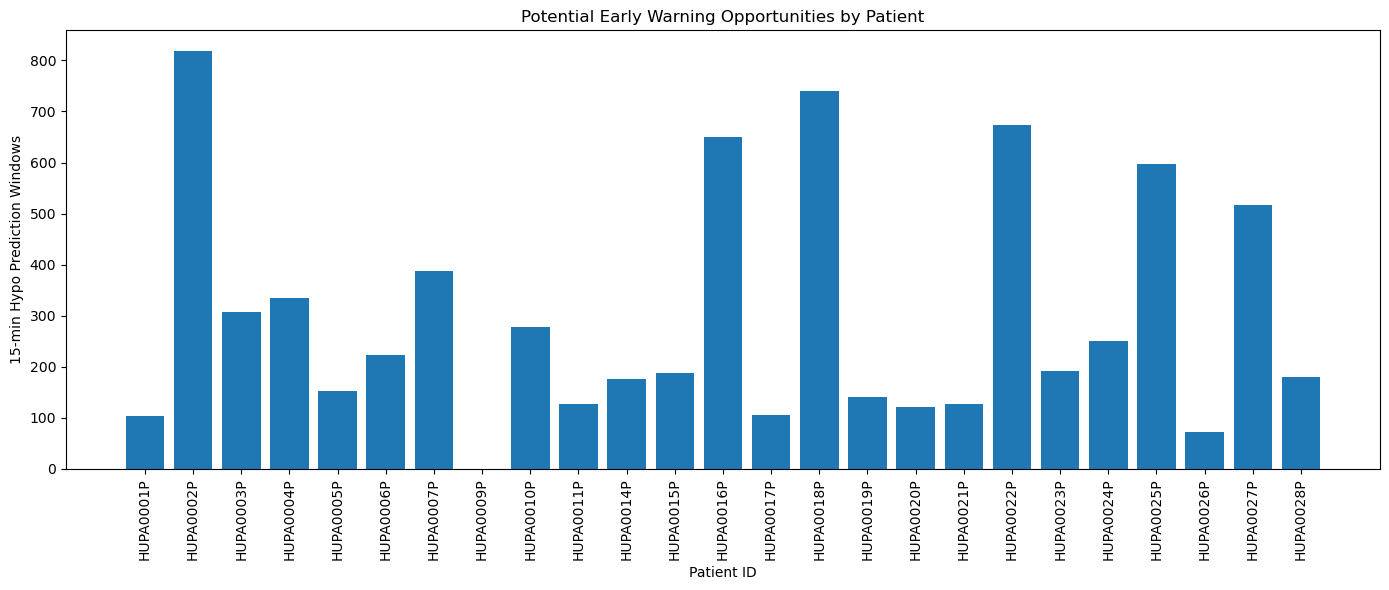

In [12]:
# --- Step 1: Sort and prepare ---
merged_df = merged_df.sort_values(['patient_id', 'time'])
merged_df['time'] = pd.to_datetime(merged_df['time'])

# --- Step 2: Flag hypoglycemia events (<70 mg/dL) ---
threshold = 70
merged_df['hypo_event'] = (merged_df['glucose'] < threshold).astype(int)

# --- Step 3: Create HR-based predictive features ---
window = '10min'
features = []

for pid, group in merged_df.groupby('patient_id'):
    g = group.set_index('time')
    g['hr_mean_10m'] = g['heart_rate'].rolling(window=window).mean()
    g['hr_std_10m'] = g['heart_rate'].rolling(window=window).std()
    g['hr_delta'] = g['heart_rate'].diff()
    # Mark windows 15 minutes before hypo events
    g['hypo_ahead_15m'] = (
        g['hypo_event']
        .shift(-1)
        .rolling('15min')
        .max()
        .fillna(0)
        .astype(int)
    )
    features.append(g.reset_index())

feature_df = pd.concat(features).sort_values(['patient_id', 'time'])

# --- Step 4: Summary of predicted hypo windows per patient ---
summary = feature_df.groupby('patient_id')['hypo_ahead_15m'].sum().reset_index()
summary = summary.rename(columns={'hypo_ahead_15m': 'predicted_hypo_windows'})

plt.figure(figsize=(14, 6))  # Wider figure
plt.bar(summary['patient_id'], summary['predicted_hypo_windows'])
plt.xlabel('Patient ID')
plt.ylabel('15-min Hypo Prediction Windows')
plt.title('Potential Early Warning Opportunities by Patient')
plt.xticks(rotation=90, ha='center')  # Rotate labels
plt.tight_layout()  # Adjust spacing
plt.show()

